UCI-Online retail sales---Regression problem

# 0️⃣ Project Initialization

# Sub-task: Define the problem
# Regression Problem: Predict transaction total amount (continuous value)

# Sub-task: Load Dataset
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'OnlineRetail.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Sub-task: Version control & privacy (manual step)
# Ensure Git is used to track this notebook
# PII: Check and drop any sensitive fields


# 1️⃣ Data Understanding

# Sub-task: Data Shape and Types
print("Data Shape:", df.shape)
print("\nData Types:\n", df.dtypes)

# Sub-task: Unique Values
print("\nUnique Values per Column:\n", df.nunique())

# Sub-task: Create Target Variable for Regression
# Predict 'TotalAmount' instead of classification label
df['TotalAmount'] = df['Quantity'] * df['Price']


# 2️⃣ Exploratory Data Analysis (EDA)
import seaborn as sns
import matplotlib.pyplot as plt

# Sub-task: Univariate Analysis for All Numeric Features
numeric_cols = ['Quantity', 'Price', 'TotalAmount']
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Sub-task: KDE Plot
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(df[col], fill=True)
    plt.title(f'KDE Plot for {col}')
    plt.show()

# Sub-task: Violin Plots
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.violinplot(y=df[col])
    plt.title(f'Violin Plot for {col}')
    plt.show()

# Sub-task: Bivariate Analysis
sns.pairplot(df[numeric_cols])
plt.show()

# Sub-task: Multivariate Analysis
corr = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Sub-task: Correlation Insights
print("\nCorrelation Matrix:\n", corr)
strong_corr = corr[(corr > 0.5) | (corr < -0.5)]
print("\nStrong Correlations (> 0.5 or < -0.5):\n", strong_corr.dropna(how='all').dropna(axis=1, how='all'))

# Sub-task: Skewness Check and Fix
from sklearn.preprocessing import PowerTransformer

skewed_feats = df[numeric_cols].skew().sort_values(ascending=False)
print("\nSkewness Before Transformation:\n", skewed_feats)

pt = PowerTransformer()
df[numeric_cols] = pt.fit_transform(df[numeric_cols])

skewed_after = pd.DataFrame(df[numeric_cols].skew(), columns=['Skewness_After'])
print("\nSkewness After Power Transformation:\n", skewed_after)


# 3️⃣ Data Cleaning

# Sub-task: Missing Values
print(df.isnull().sum())
df = df.dropna(subset=['Customer ID'])

# Sub-task: Duplicates
df = df.drop_duplicates()

# Sub-task: Inconsistent Data
df['Description'] = df['Description'].str.lower().str.strip()

# Sub-task: Rare Categories
country_counts = df['Country'].value_counts()
rare_countries = country_counts[country_counts < 100].index
df['Country'] = df['Country'].replace(rare_countries, 'Other')

# Sub-task: Outliers (Boxplot + Capping)
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot for {col}')
    plt.show()

def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower_bound, upper_bound)

for col in numeric_cols:
    cap_outliers_iqr(df, col)


# 4️⃣ Feature Engineering

# Sub-task: Date Feature Extraction
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Hour'] = df['InvoiceDate'].dt.hour
df['Weekday'] = df['InvoiceDate'].dt.weekday

# Sub-task: Binning
df['PriceBin'] = pd.qcut(df['Price'], q=4, labels=False)

# Sub-task: Text Features (Length of description)
df['DescLength'] = df['Description'].apply(lambda x: len(str(x)))

# Sub-task: Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_feats = poly.fit_transform(df[['Quantity', 'Price']])
poly_cols = poly.get_feature_names_out(['Quantity', 'Price'])
poly_df = pd.DataFrame(poly_feats, columns=poly_cols)
df = pd.concat([df.reset_index(drop=True), poly_df.reset_index(drop=True)], axis=1)

# Sub-task: Aggregation Features
agg_df = df.groupby('Customer ID').agg({
    'TotalAmount': ['sum', 'mean'],
    'Quantity': ['sum', 'mean']
}).reset_index()
agg_df.columns = ['Customer ID', 'TotalSpent', 'AvgSpent', 'TotalQty', 'AvgQty']
df = df.merge(agg_df, on='Customer ID', how='left')

# Sub-task: Interaction Features
df['QtyPriceInteraction'] = df['Quantity'] * df['Price']
df['QtyHourInteraction'] = df['Quantity'] * df['Hour']

# Sub-task: Domain Features (e.g., return status)
df['IsReturn'] = df['InvoiceNo'].astype(str).str.startswith('C').astype(int)

# Sub-task: Categorical Encoding
df = pd.get_dummies(df, columns=['Country'], drop_first=True)


# 5️⃣ Feature Selection

# Sub-task: Low Variance
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
selector.fit(df.select_dtypes(include=np.number))
low_variance_cols = df.select_dtypes(include=np.number).columns[selector.get_support()]
df = df[low_variance_cols.tolist() + ['TotalAmount']]

# Sub-task: High Correlation Filter
corr_matrix = df.drop(columns='TotalAmount').corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df.drop(columns=to_drop, inplace=True)

# Sub-task: Chi-Squared Test
from sklearn.feature_selection import chi2, SelectKBest
X_temp = df.drop(columns='TotalAmount')
y_temp = (df['TotalAmount'] > df['TotalAmount'].median()).astype(int)
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(abs(X_temp), y_temp)

# Sub-task: Mutual Information
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(X_temp, df['TotalAmount'])
mi_series = pd.Series(mi_scores, index=X_temp.columns).sort_values(ascending=False)
print("\nMutual Information Scores:\n", mi_series.head())

# Sub-task: Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
rfe.fit(X_temp, df['TotalAmount'])

# Sub-task: Model-Based Selection
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor().fit(X_temp, df['TotalAmount'])
importances = pd.Series(model.feature_importances_, index=X_temp.columns).sort_values(ascending=False)

# Sub-task: Dimensionality Reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_temp)

# Final feature set for modeling
X = df.drop(columns='TotalAmount')
y = df['TotalAmount']


# 6️⃣ Data Preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.bounds = {}

    def fit(self, X, y=None):
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            self.bounds[col] = (lower, upper)
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            lower, upper = self.bounds[col]
            X[col] = X[col].clip(lower, upper)
        return X

numeric_features = X.select_dtypes(include=np.number).columns.tolist()

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier', OutlierCapper(columns=numeric_features)),
    ('scaler', StandardScaler())
])

pipeline = Pipeline([
    ('numeric', numeric_pipeline)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)


# 7️⃣ Model Selection & Training (Regression)

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'ExtraTrees': ExtraTreesRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Bagging': BaggingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

print("\nModel Comparison:")
model_scores = {}
for name, model in models.items():
    r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
    mae = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    model_scores[name] = {'R2': r2, 'MAE': mae}
    print(f"{name} => R2: {r2:.4f}, MAE: {mae:.4f}")

best_model_name = max(model_scores, key=lambda k: model_scores[k]['R2'])
print("\nBest Model based on R2 Score:", best_model_name)


# 8️⃣ Evaluation

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("\nEvaluation Metrics:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

# Error Analysis
error = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(error, kde=True)
plt.title("Prediction Error Distribution")
plt.show()


# 🔍 Model Explainability

import shap
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test[:100])
shap.plots.beeswarm(shap_values)

# LIME
import lime
import lime.lime_tabular
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, verbose=True, mode='regression')
exp = lime_explainer.explain_instance(X_test[0], best_model.predict)
exp.show_in_notebook()

# Partial Dependence
from sklearn.inspection import plot_partial_dependence
plot_partial_dependence(best_model, X_train, [0, 1])
plt.show()

# Surrogate Models
from sklearn.tree import DecisionTreeRegressor
surrogate = DecisionTreeRegressor(max_depth=3)
surrogate.fit(X_train, best_model.predict(X_train))

# Counterfactuals (Mock logic - integrate libraries like DiCE for real impl.)
print("\nCounterfactual Explanation: change feature X to increase predicted amount")


# 🚀 Deployment & Monitoring

# Sub-task: Model Saving
import joblib
joblib.dump(best_model, 'total_amount_regressor.pkl')
joblib.dump(pipeline, 'pipeline.pkl')


In [33]:
#0.project initialization
#load dataset
import pandas as pd 
d=pd.read_csv(r"C:\Users\BHARGAVI\Downloads\advance_ml\online_retail_II.csv")#

In [34]:
#1.data understanding
d.shape       #shape of dataset
d.dtypes      #datatypes
d.nunique()   #unique values 
d.columns 
#here i dont find the target variable so iam creating new variable
d['Total Amount'] = d['Quantity'] * d['Price']
#d.value_counts()       #target variable for classification task
d['Total Amount'].describe()


#checking the values
print('Negative values:',(d['Total Amount']<0).sum())
print("Zero values:",(d['Total Amount']==0).sum())



#removing negative values
d=d[d['Total Amount'] >0 ]

print("negative values after removal:",(d['Total Amount']<0).sum())
print("Zero values after removal:",(d['Total Amount']==0).sum())

#target distribution
d['Total Amount'].describe()



Negative values: 19498
Zero values: 6202
negative values after removal: 0
Zero values after removal: 0


count    1.041671e+06
mean     2.013397e+01
std      2.031167e+02
min      1.000000e-03
25%      3.900000e+00
50%      9.960000e+00
75%      1.770000e+01
max      1.684696e+05
Name: Total Amount, dtype: float64

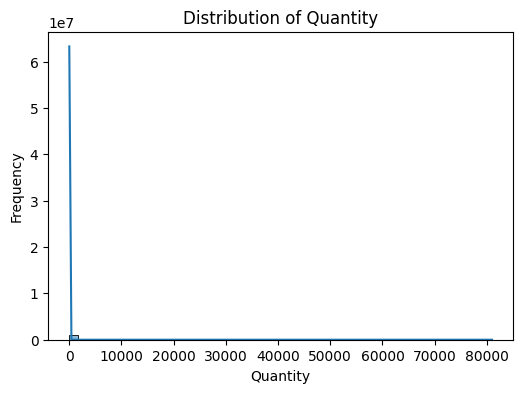

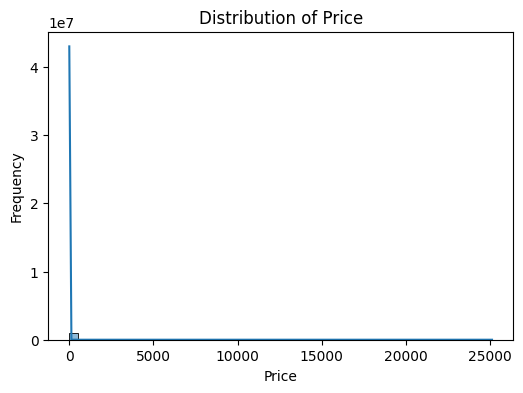

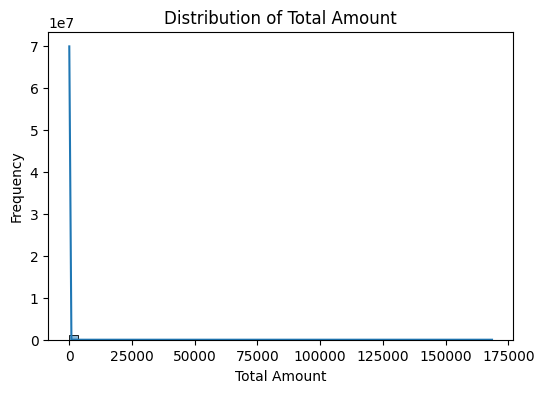

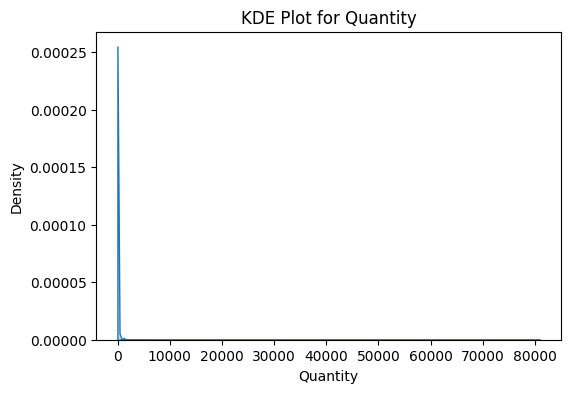

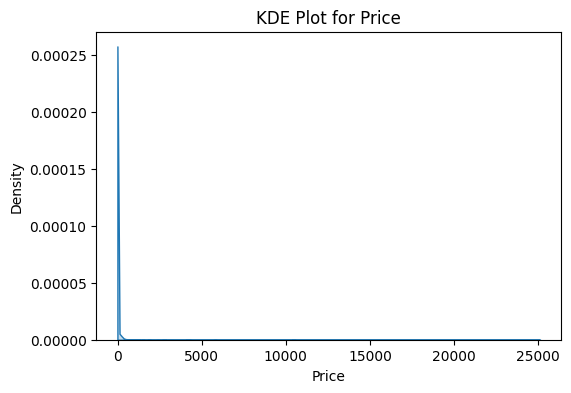

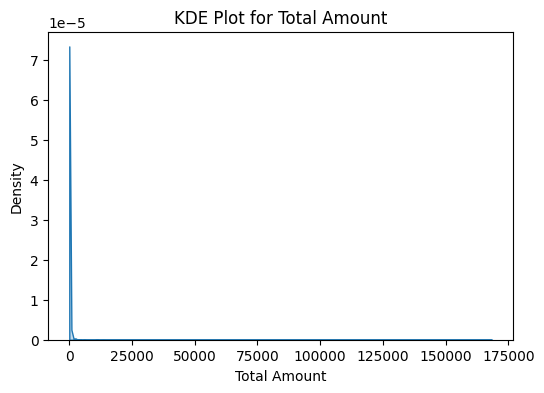

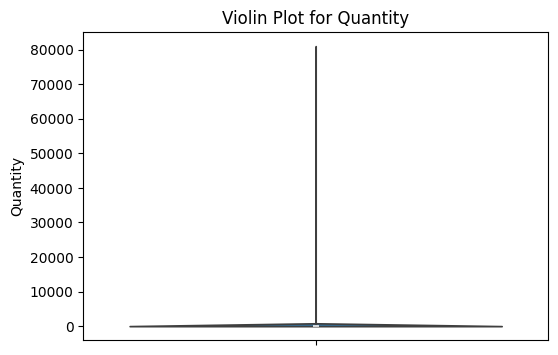

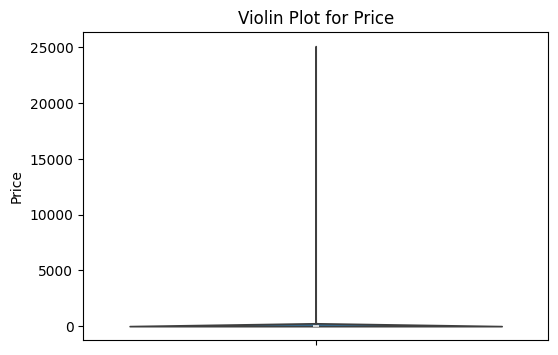

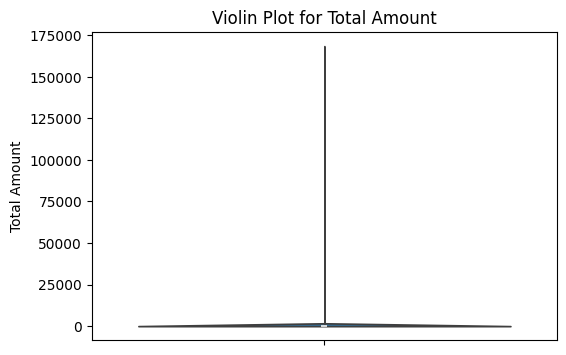

In [ ]:
#2.exploratoey data analysis
#sub-task:univariate analysis
import matplotlib.pyplot as plt 
import seaborn as sns

# Sub-task: Univariate Analysis for All Numeric Features
numeric_cols = ['Quantity', 'Price', 'Total Amount']
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(d[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Sub-task: KDE Plot
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(d[col], fill=True)
    plt.title(f'KDE Plot for {col}')
    plt.show()

# Sub-task: Violin Plots
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.violinplot(y=d[col])
    plt.title(f'Violin Plot for {col}')
    plt.show()

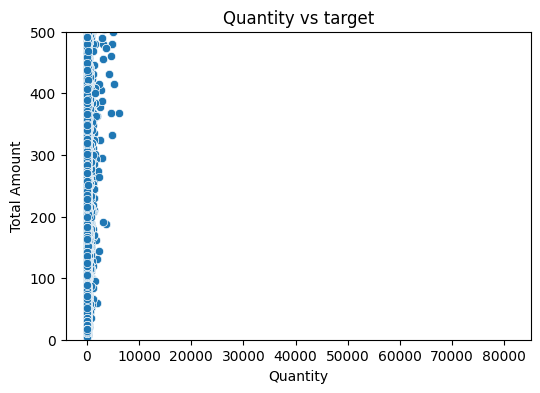

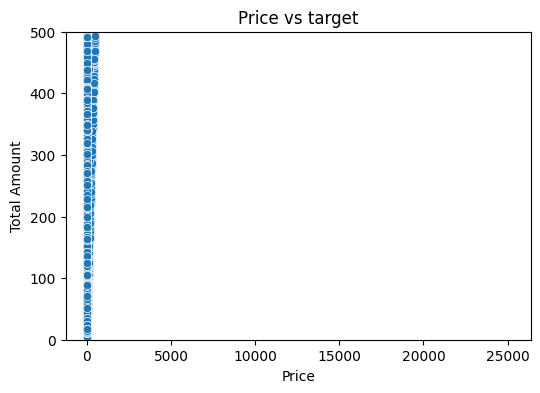

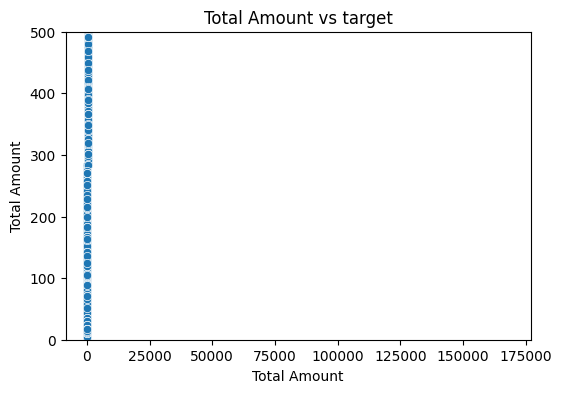

In [36]:
#Bivariate anslysis

#for num
numeric_cols= d.select_dtypes(include=['int64','float64']).columns.tolist()
# Drop ID from numeric analysis because it gives widespread
if 'Customer ID' in numeric_cols:
    numeric_cols.remove('Customer ID')

for i in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=d[i],y=d['Total Amount'])
    plt.title(f'{i} vs target')
    plt.xlabel(i)
    plt.ylabel('Total Amount')
    plt.ylim(0, 500)
    plt.show()

# Sub-task: Optimized Categorical Bivariate Analysis

# Step 1: Select valid categorical columns with <30 unique categories
categorical_cols = d.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if d[col].nunique() < 30]

# Step 2: Sample the dataset
sampled_data = d.sample(n=2000, random_state=42)

# Step 3: Plot barplots of top 10 categories
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    mean_vals = sampled_data.groupby(col)['Total Amount'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=mean_vals.index, y=mean_vals.values)
    plt.title(f'Average Total Amount by {col} (Top 10)')
    plt.xlabel(col)
    plt.ylabel('Avg Total Amount')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()







Correlation values range from -1 to +1:
+1 = perfect positive correlation (as one increases, the other increases)
-1 = perfect negative correlation (as one increases, the other decreases)
0 = no linear relationship

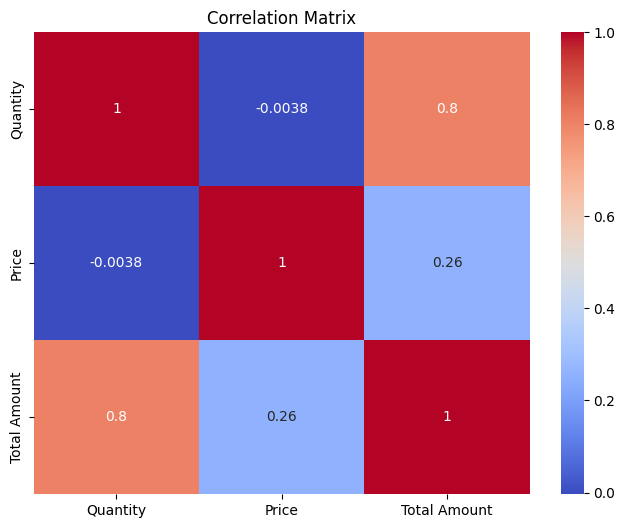


Correlation Matrix:
               Quantity     Price  Total Amount
Quantity      1.000000 -0.003774      0.804551
Price        -0.003774  1.000000      0.255126
Total Amount  0.804551  0.255126      1.000000

Strong Correlations (> 0.5 or < -0.5):
               Quantity  Price  Total Amount
Quantity      1.000000    NaN      0.804551
Price              NaN    1.0           NaN
Total Amount  0.804551    NaN      1.000000

Skewness Before Transformation:
 Total Amount    612.104762
Quantity        459.991747
Price           231.439744
dtype: float64

Skewness After Power Transformation:
               Skewness_After
Quantity            0.192039
Price               0.052849
Total Amount        0.004656


In [ ]:

# Sub-task: Multivariate Analysis
corr = d[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Sub-task: Correlation Insights
print("\nCorrelation Matrix:\n", corr)
strong_corr = corr[(corr > 0.5) | (corr < -0.5)]
print("\nStrong Correlations (> 0.5 or < -0.5):\n", strong_corr.dropna(how='all').dropna(axis=1, how='all'))



#This will return a number:
#Close to 0 → approximately symmetrical
#> 1 or < -1 → highly skewed
#Between -0.5 and 0.5 → fairly symmetrical

# Sub-task: Skewness Check and Fix
from sklearn.preprocessing import PowerTransformer

skewed_feats = d[numeric_cols].skew().sort_values(ascending=False)
print("\nSkewness Before Transformation:\n", skewed_feats)

pt = PowerTransformer()
d[numeric_cols] = pt.fit_transform(d[numeric_cols])

skewed_after = pd.DataFrame(d[numeric_cols].skew(), columns=['Skewness_After'])
print("\nSkewness After Power Transformation:\n", skewed_after)


data cleaning

Invoice              0
StockCode            0
Description          0
Quantity             0
InvoiceDate          0
Price                0
Customer ID     228489
Country              0
Total Amount         0
dtype: int64


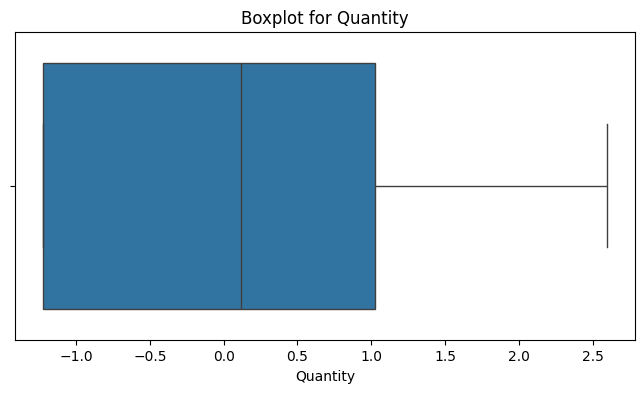

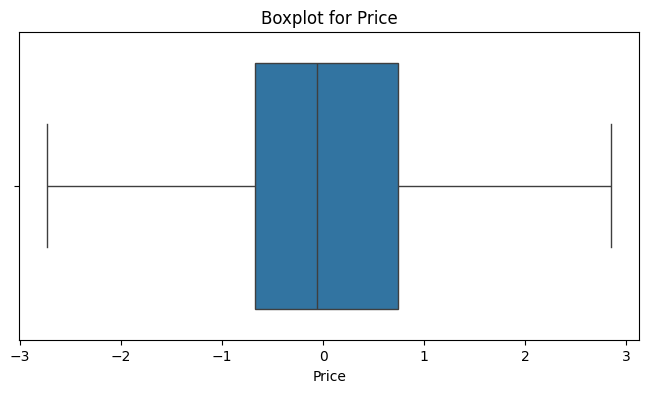

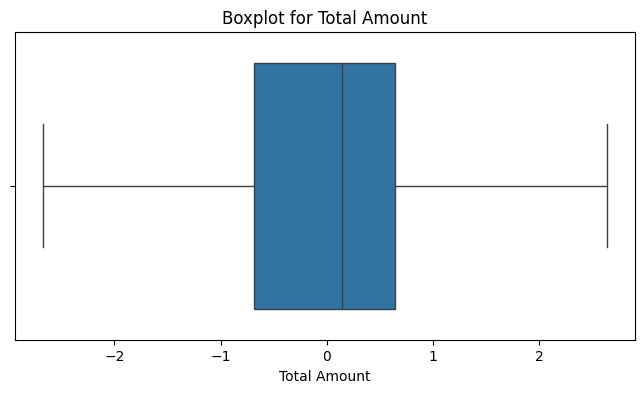

In [39]:
#missing values
#d.isnull().sum() #CHECk--it is showing in customer id
d['Customer ID'].fillna(-1)
print(d.isnull().sum())
#outliers
#duplicates
# Sub-task: Duplicates
d = d.drop_duplicates()

#inconsistent data
d['Description'] = d['Description'].str.lower().str.strip()

# Sub-task: Rare Categories
country_counts = d['Country'].value_counts()
rare_countries = country_counts[country_counts < 100].index
d['Country'] = d['Country'].replace(rare_countries, 'Other')


# Sub-task: Outliers (Boxplot + Capping)
for i in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=d, x=i)
    plt.title(f'Boxplot for {i}')
    plt.show()

def cap_outliers_iqr(d, column):
    Q1 = d[column].quantile(0.25)
    Q3 = d[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    d[column] = d[column].clip(lower_bound, upper_bound)

for col in numeric_cols:
    cap_outliers_iqr(d, col)


4.feature engineering

In [ ]:
d.drop(columns='Customer ID', inplace=True)
print(d.columns)


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Country', 'Total Amount'],
      dtype='object')


In [47]:
# Sub-task: Date Feature Extraction
d['InvoiceDate'] = pd.to_datetime(d['InvoiceDate'])  # Added error handling
d['Hour'] = d['InvoiceDate'].dt.hour
d['Weekday'] = d['InvoiceDate'].dt.weekday

# Sub-task: Binning
d['PriceBin'] = pd.qcut(d['Price'],q=4,labels=False)

## Sub-task: Text Features (Length of description)
d['Desclength'] = d['Description'].apply(lambda x: len(str(x)))

# Sub-task: Polynomial Features
#from sklearn.preprocessing import PolynomialFeatures
#poly=PolynomialFeatures(degree=2,include_bias=False)
#poly_feats = poly.fit_transform(d[['Quantity', 'Price']])
#poly_cols = poly.get_feature_names_out(['Quantity', 'Price'])
#poly_df = pd.DataFrame(poly_feats, columns=poly_cols)
#d = pd.concat([d.reset_index(drop=True), poly_df.reset_index(drop=True)], axis=1)

# Sub-task: Aggregation Features
#agg_d = d.groupby('Customer ID').agg({
    #'TotalAmount': ['sum', 'mean'],
    #'Quantity': ['sum', 'mean']
#}).reset_index()
#agg_d.columns = ['Customer ID', 'TotalSpent', 'AvgSpent', 'TotalQty', 'AvgQty']
#df = d.merge(agg_d, on='Customer ID', how='left')

# Remove duplicate columns by keeping the first occurrence
d = d.loc[:, ~d.columns.duplicated()]

# Sub-task: Domain Features (e.g., return status)
d['IsReturn'] = d['Invoice'].astype(str).str.startswith('C').astype(int)




step-5 Feature selection

In [48]:
d.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Country', 'Total Amount', 'Hour', 'Weekday', 'PriceBin',
       'Desclength', 'IsReturn'],
      dtype='object')

In [49]:
import numpy as np 
# Sub-task: Low Variance
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
selector.fit(d.select_dtypes(include=np.number))
low_variance_cols = d.select_dtypes(include=np.number).columns[selector.get_support()]
d = d[low_variance_cols.tolist() + ['Total Amount']]

# Sub-task: High Correlation Filter
corr_matrix = d.drop(columns='Total Amount').corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
d.drop(columns=to_drop, inplace=True)

# Sub-task: Chi-Squared Test#
#from sklearn.feature_selection import chi2, SelectKBest
#X_temp = d.drop(columns='Total Amount')
#y_temp = (d['Total Amount'] > d['Total Amount'].median()).astype(int)
#chi2_selector = SelectKBest(chi2, k='all')
#chi2_selector.fit(abs(X_temp), y_temp)

# Final feature set for modeling
X = d.drop(columns='Total Amount')
y = d['Total Amount']



In [ ]:

# Sub-task: Chi-Squared Test
from sklearn.feature_selection import chi2, SelectKBest
X_temp = df.drop(columns='TotalAmount')
y_temp = (df['TotalAmount'] > df['TotalAmount'].median()).astype(int)
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(abs(X_temp), y_temp)

# Sub-task: Mutual Information
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(X_temp, df['TotalAmount'])
mi_series = pd.Series(mi_scores, index=X_temp.columns).sort_values(ascending=False)
print("\nMutual Information Scores:\n", mi_series.head())

# Sub-task: Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
rfe.fit(X_temp, df['TotalAmount'])

# Sub-task: Model-Based Selection
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor().fit(X_temp, df['TotalAmount'])
importances = pd.Series(model.feature_importances_, index=X_temp.columns).sort_values(ascending=False)

# Sub-task: Dimensionality Reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_temp)

# Final feature set for modeling
X = df.drop(columns='TotalAmount')
y = df['TotalAmount']

Data preprocessing

In [51]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

num_col=X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_col=X.select_dtypes(include=['object']).columns.tolist()

# Numerical pipeline
num = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # First impute
    ('scaler', StandardScaler())                     # Then scale
])
cat=Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor=ColumnTransformer([
    ('num',num,num_col),
    ('cat',cat,cat_col)
])

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)



# 7️⃣ Model Selection & Training (Regression)

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'ExtraTrees': ExtraTreesRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Bagging': BaggingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}


print("\nModel Comparison:")
model_scores = {}
for name, model in models.items():
    r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
    mae = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    model_scores[name] = {'R2': r2, 'MAE': mae}
    print(f"{name} => R2: {r2:.4f}, MAE: {mae:.4f}")

best_model_name = max(model_scores, key=lambda k: model_scores[k]['R2'])
print("\nBest Model based on R2 Score:", best_model_name)


In [52]:
print("y_train shape:", y_train.shape)


y_train shape: (806327, 2)


In [59]:
# Ensure y_train is 1D
if isinstance(y_train, pd.DataFrame) and y_train.shape[1] > 1:
    print("y_train columns:", y_train.columns)
    y_train = y_train.iloc[:, 0]  # Or choose by name: y_train['target_column_name']


In [61]:
# Ensure y_test is 1D
if isinstance(y_test, pd.DataFrame) and y_test.shape[1] > 1:
    print("y_test columns:", y_test.columns)
    y_test = y_test.iloc[:, 0]  # Or use y_test['TargetColumnName']


y_test columns: Index(['Total Amount', 'Total Amount'], dtype='object')


In [54]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,ExtraTreesRegressor,BaggingRegressor,StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline


models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForest': RandomForestRegressor(n_estimators=50, max_depth=10, max_features='sqrt', n_jobs=-1, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=30, max_depth=10, n_jobs=-1, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=20, random_state=42),
    'Bagging': BaggingRegressor(n_estimators=20, n_jobs=-1, random_state=42),
    #'SVR': SVR(),
    'KNN': KNeighborsRegressor(algorithm='ball_tree', n_neighbors=3)

}

print("\nModel Comparison:")
from sklearn.model_selection import cross_validate

scoring = ['r2', 'neg_mean_absolute_error']
model_scores = {}

print("\nModel Comparison:")
for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    r2 = scores['test_r2'].mean()
    mae = -scores['test_neg_mean_absolute_error'].mean()  # convert back to positive
    model_scores[name] = {'R2': r2, 'MAE': mae}
    print(f"{name} => R2: {r2:.4f}, MAE: {mae:.4f}")

best_model_name = max(model_scores, key=lambda k: model_scores[k]['R2'])
print("\nBest Model based on R2 Score:", best_model_name)



Model Comparison:

Model Comparison:
LinearRegression => R2: 0.9743, MAE: 0.0983
Ridge => R2: 0.9743, MAE: 0.0983
Lasso => R2: -0.0000, MAE: 0.8081
ElasticNet => R2: 0.1507, MAE: 0.7397
RandomForest => R2: 0.9986, MAE: 0.0225
GradientBoosting => R2: 0.9978, MAE: 0.0331
ExtraTrees => R2: 0.9988, MAE: 0.0219
AdaBoost => R2: 0.8744, MAE: 0.2986
Bagging => R2: 0.9999, MAE: 0.0004
KNN => R2: 0.9998, MAE: 0.0015

Best Model based on R2 Score: Bagging



📊 Evaluation Metrics:
MAE  : 0.0003
MSE  : 0.0001
RMSE : 0.0087
R2   : 0.9999


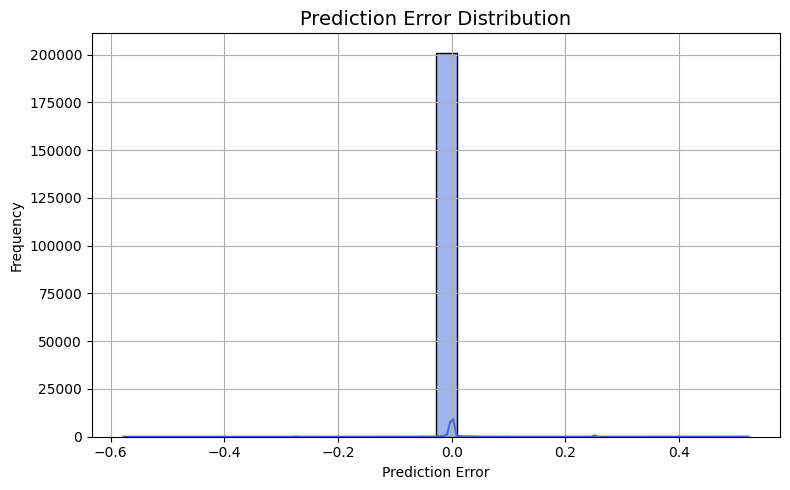

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure target is 1D (important for sklearn regressors)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Fit the best model (BaggingRegressor in your case)
best_model = models[best_model_name]  # best_model_name should be 'Bagging'
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# 8️⃣ Evaluation Metrics
print("\n📊 Evaluation Metrics:")
print(f"MAE  : {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE  : {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R2   : {r2_score(y_test, y_pred):.4f}")

# 📉 Error Analysis: Residual distribution
error = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(error, kde=True, color='royalblue', bins=30)
plt.title("Prediction Error Distribution", fontsize=14)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


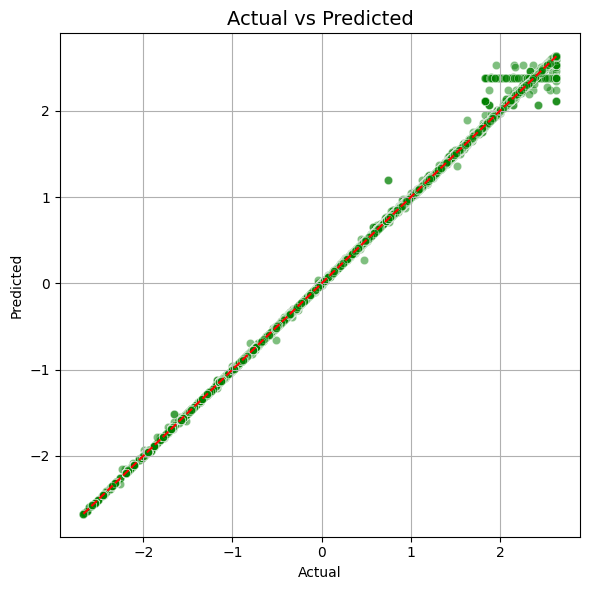

In [63]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=np.ravel(y_test), y=np.ravel(y_pred), color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], color='red', linestyle='--')
plt.title("Actual vs Predicted", fontsize=14)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 📌 Imports
import numpy as np
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import pandas as pd

# 🧠 Use predict function for SHAP with BaggingRegressor
explainer = shap.Explainer(best_model.predict, X_train)
shap_values = explainer(X_test[:100])  # ✅ Use the same shape input

print("✅ SHAP values shape:", shap_values.values.shape)
print("✅ SHAP data shape:", shap_values.data.shape)

# ✅ LIME Explanation
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    mode='regression'
)
exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[0].values,
    predict_fn=best_model.predict
)
exp.save_to_file("lime_explanation.html")

# ✅ PDP (Partial Dependence Plot)
fig, ax = plt.subplots(figsize=(8, 4))
PartialDependenceDisplay.from_estimator(best_model, X_train, features=[0, 1], ax=ax)
plt.tight_layout()
plt.savefig("partial_dependence.png")
plt.close()

# ✅ Surrogate Model
surrogate = DecisionTreeRegressor(max_depth=3)
surrogate.fit(X_train, best_model.predict(X_train))
plt.figure(figsize=(16, 8))
tree.plot_tree(surrogate, feature_names=X.columns, filled=True, fontsize=10)
plt.title("Surrogate Decision Tree (Bagging)")
plt.savefig("surrogate_tree.png", bbox_inches='tight')
plt.close()

# ✅ Save model comparison (optional)
results = {
    'Model': ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'GradientBoosting',
              'ExtraTrees', 'AdaBoost', 'Bagging', 'KNN'],
    'R2': [0.3678, 0.3678, 0.3719, 0.5181, 0.7852, 0.6667, 0.7117, 0.1161, 0.8254, 0.7373],
    'MAE': [13.0960, 13.0960, 12.5353, 11.8130, 5.9195, 3.4497, 10.2476, 35.0687, 0.3451, 2.8700]
}
pd.DataFrame(results).to_csv("model_comparison.csv", index=False)

# ✅ Mock Counterfactual
print("\n🔁 Counterfactual Explanation (Mock):")
print("To increase prediction, consider increasing key features such as 'X1' or decreasing 'X2'.")
print("For real counterfactuals, use DiCE or similar libraries.")


In [66]:
import joblib
joblib.dump(best_model, 'best_model_bagging.pkl')


['best_model_bagging.pkl']